In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
!pip install xgboost
!pip install pushbullet.py
!pip install python-dotenv
!pip install fastparquet
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from pushbullet import Pushbullet
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
# dotenv
from dotenv import load_dotenv
import os
from google.colab import userdata
# Load environment variables
load_dotenv()

# Pushbullet API key
#API_KEY = os.getenv("API_KEY")
API_KEY = userdata.get('API_KEY')



In [4]:

# df = pd.read_csv('flight_data_2018_2024.csv')
df_parquet = pd.read_parquet('/content/flight_data.parquet', engine='fastparquet')

original_shape = df_parquet.shape
number_of_nulls = df_parquet.isnull().count()

#drop rows that have more than 50% null values
df_parquet.dropna(thresh=df_parquet.shape[1]/2, inplace=True)
#drop columns that have more than 50% null values
df_parquet.dropna(axis=1, thresh=df_parquet.shape[0]/2, inplace=True)
#drop the row if duplicate column has Y value
after_drop_shape = df_parquet.shape

# convert the FlightDate column to datetime
df_parquet['FlightDate'] = pd.to_datetime(df_parquet['FlightDate'])


number_of_unique_values = df_parquet.nunique()
data_types = df_parquet.dtypes
number_of_rows = len(df_parquet)

print("number_of_nulls", "\n", number_of_nulls, "\n", "number_of_unique_values", "\n", number_of_unique_values, "\n", "data_types", "\n", data_types, "\n", "number_of_rows", "\n", number_of_rows, "\n", "original_shape", "\n", original_shape, "\n", "after_drop_shape", "\n", after_drop_shape)


number_of_nulls 
 Year                582425
Quarter             582425
Month               582425
DayofMonth          582425
DayOfWeek           582425
                     ...  
Div5LongestGTime    582425
Div5WheelsOff       582425
Div5TailNum         582425
Duplicate           582425
Unnamed: 119        582425
Length: 120, dtype: int64 
 number_of_unique_values 
 Year                     1
Quarter                  1
Month                    1
DayofMonth              31
DayOfWeek                7
                      ... 
Flights                  1
Distance              1504
DistanceGroup           11
DivAirportLandings       5
Duplicate                1
Length: 62, dtype: int64 
 data_types 
 Year                    int64
Quarter                 int64
Month                   int64
DayofMonth              int64
DayOfWeek               int64
                       ...   
Flights               float64
Distance              float64
DistanceGroup           int64
DivAirportLandings      

In [5]:
df_parquet.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,Cancelled,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,DivAirportLandings,Duplicate
0,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,0.0,0.0,104.0,78.0,48.0,1.0,209.0,1,0,N
1,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,0.0,0.0,79.0,106.0,41.0,1.0,212.0,1,0,N
2,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,0.0,0.0,76.0,88.0,41.0,1.0,209.0,1,0,N
3,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,0.0,0.0,88.0,113.0,51.0,1.0,258.0,2,0,N
4,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,0.0,0.0,123.0,108.0,83.0,1.0,696.0,3,0,N


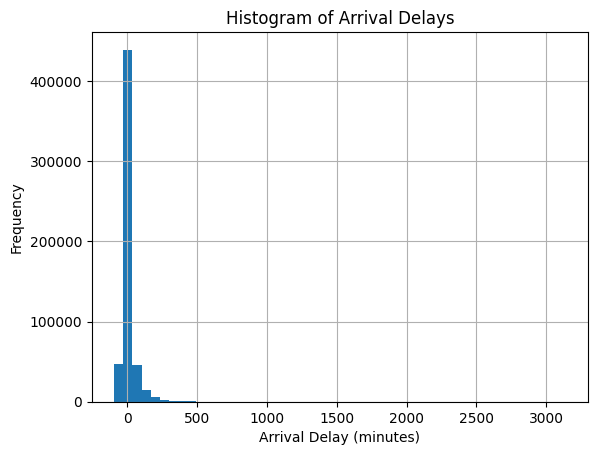

In [6]:

df = df_parquet.copy()
df['ArrDelay'].hist(bins=50)
plt.title('Histogram of Arrival Delays')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.show()


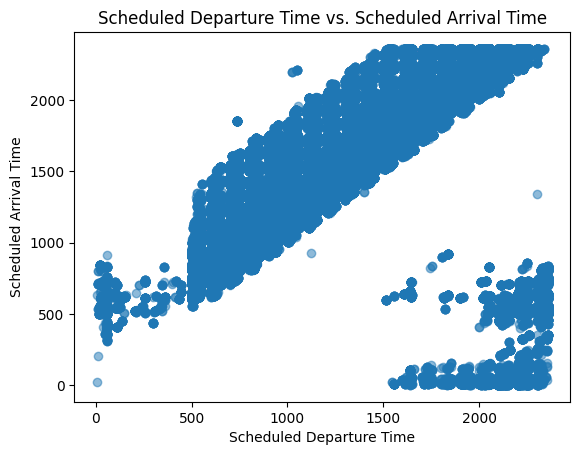

In [7]:
plt.scatter(df['CRSDepTime'], df['CRSArrTime'], alpha=0.5)
plt.title('Scheduled Departure Time vs. Scheduled Arrival Time')
plt.xlabel('Scheduled Departure Time')
plt.ylabel('Scheduled Arrival Time')
plt.show()


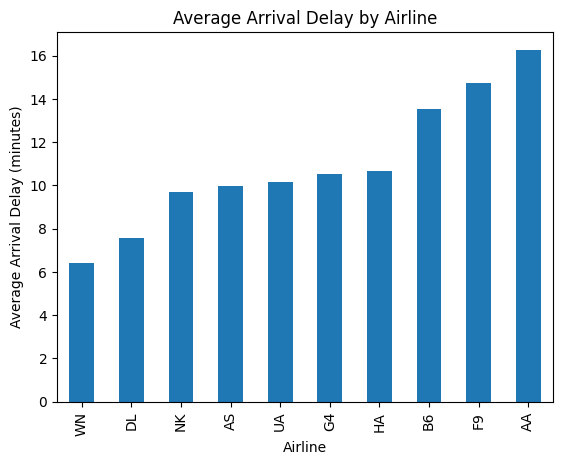

In [8]:
carrier_delay = df.groupby('Marketing_Airline_Network')['ArrDelay'].mean().sort_values()
carrier_delay.plot(kind='bar')
plt.title('Average Arrival Delay by Airline')
plt.xlabel('Airline')
plt.ylabel('Average Arrival Delay (minutes)')
plt.show()


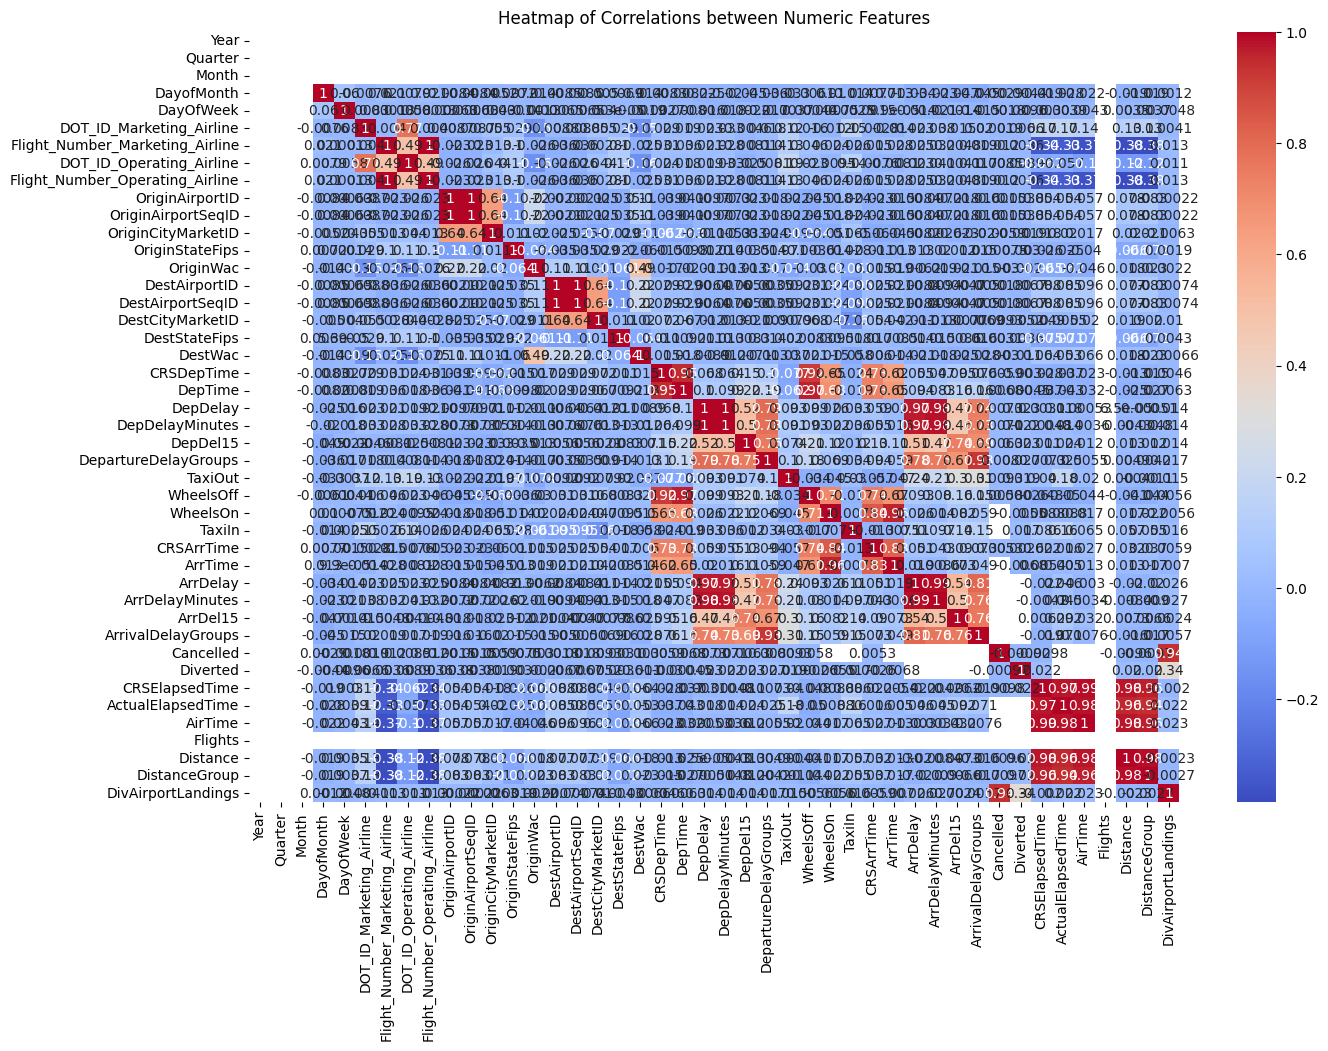

In [9]:

df_numeric = df.select_dtypes(include=['number'])

plt.figure(figsize=(15, 10))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Correlations between Numeric Features')
plt.show()


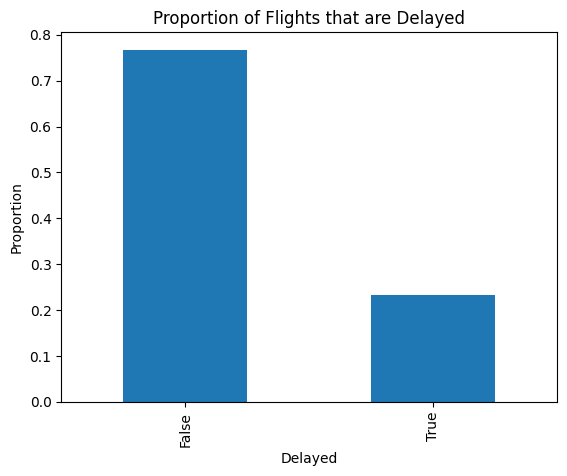

In [10]:
df_parquet['is_delayed'] = df_parquet['ArrDelayMinutes'] > 15

df_parquet['is_delayed'].value_counts(normalize=True).plot(kind='bar')
plt.title('Proportion of Flights that are Delayed')
plt.xlabel('Delayed')
plt.ylabel('Proportion')
plt.show()


In [11]:
df_parquet['is_delayed'] = df_parquet['ArrDelayMinutes'] > 15
columns_to_drop = [
    'DepDelay', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups',
    'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups',
    'Cancelled', 'Diverted', 'DepTime', 'ArrTime', 'Duplicate'
]

df_parquet = df_parquet.drop(columns=columns_to_drop)
#convert datetime64 to float64
df_parquet['FlightDate'] = df_parquet['FlightDate'].astype('int64')/10**9

#convert categorical columns to one-hot encodin
categorical_columns = df_parquet.select_dtypes(include=['object']).columns
df_parquet = pd.get_dummies(df_parquet, columns=categorical_columns)

print(df_parquet.shape)
df_sample = df_parquet.sample(10000, random_state=42)
df_sample.shape

(560515, 7648)


(10000, 7648)

In [12]:
# Pushbullet API key for notifications
pb = Pushbullet(API_KEY)

target_column = 'is_delayed'

try:
    # Separate features and target
    X = df_sample.drop(columns=target_column)
    y = df_sample[target_column]

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Initialize models
    models = {
        'KNN': KNeighborsClassifier(),
        'XGB': XGBClassifier(n_jobs=-1),
        'LogisticRegression': LogisticRegression(),
        'SVM': SVC(),
        'RandomForest': RandomForestClassifier(),
        'NaiveBayes': GaussianNB()
    }

    # Define parameter grids for GridSearchCV
    param_grids = {
        'KNN': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
        'XGB': {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]},
        'LogisticRegression': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
        'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
        'RandomForest': {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]},
        'NaiveBayes': {'var_smoothing': [1e-9, 1e-10, 1e-11]}
    }

    results = {}

    # Initialize KFold
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    for model_name, model in models.items():
        grid_search = GridSearchCV(model, param_grids[model_name], cv=kf, n_jobs=-1)
        grid_search.fit(X_train_pca, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test_pca)

        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        results[model_name] = {
            'Best Model': best_model,
            'Accuracy': accuracy,
            'Confusion Matrix': cm,
            'Best Parameters': grid_search.best_params_,
            'Best Score': grid_search.best_score_
        }

        print(f"Model: {model_name}")
        print('Accuracy:', accuracy)
        print('Confusion Matrix:\n', cm)
        print('Best Parameters:', grid_search.best_params_)
        print('Best Score:', grid_search.best_score_)
        print('-' * 30)

except Exception as e:
    try:

        pb.push_note("Modeling", f"Modeling has crashed: {str(e)}")
    except Exception as e:
        print("Error sending notification:", e)

results

Model: KNN
Accuracy: 0.757
Confusion Matrix:
 [[1514    3]
 [ 483    0]]
Best Parameters: {'n_neighbors': 9, 'weights': 'uniform'}
Best Score: 0.768875
------------------------------
Model: XGB
Accuracy: 0.728
Confusion Matrix:
 [[1401  116]
 [ 428   55]]
Best Parameters: {'max_depth': 3, 'n_estimators': 100}
Best Score: 0.78425
------------------------------
Model: LogisticRegression
Accuracy: 0.7235
Confusion Matrix:
 [[1339  178]
 [ 375  108]]
Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.721375
------------------------------
Model: SVM
Accuracy: 0.7585
Confusion Matrix:
 [[1517    0]
 [ 483    0]]
Best Parameters: {'C': 0.1, 'kernel': 'rbf'}
Best Score: 0.7702500000000001
------------------------------
Model: RandomForest
Accuracy: 0.7585
Confusion Matrix:
 [[1517    0]
 [ 483    0]]
Best Parameters: {'max_depth': 3, 'n_estimators': 100}
Best Score: 0.7702500000000001
------------------------------
Model: NaiveBayes
Accuracy: 0.4155
Confusion Mat

{'KNN': {'Best Model': KNeighborsClassifier(n_neighbors=9),
  'Accuracy': 0.757,
  'Confusion Matrix': array([[1514,    3],
         [ 483,    0]]),
  'Best Parameters': {'n_neighbors': 9, 'weights': 'uniform'},
  'Best Score': 0.768875},
 'XGB': {'Best Model': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=3, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=100, n_jobs=-1,
                num_parallel_t

In [15]:
import joblib
best_model = results[max(results, key=lambda k: results[k]['Best Score'])]['Best Model']
best_model.fit(X_train_pca, y_train)

joblib.dump(best_model, 'model.pkl')
try:
    pb.push_note("Modeling", "Modeling has completed successfully")
except Exception as e:
    print("Error sending notification:", e)


{'active': True,
 'iden': 'ujyZs9sDhbosjxIqpzCxye',
 'created': 1721310508.135889,
 'modified': 1721310508.135889,
 'type': 'note',
 'dismissed': False,
 'direction': 'self',
 'sender_iden': 'ujyZs9sDhbo',
 'sender_email': 'kedabaliyildirim@gmail.com',
 'sender_email_normalized': 'kedabaliyildirim@gmail.com',
 'sender_name': 'Kürşat Edabalı Yıldırım',
 'receiver_iden': 'ujyZs9sDhbo',
 'receiver_email': 'kedabaliyildirim@gmail.com',
 'receiver_email_normalized': 'kedabaliyildirim@gmail.com',
 'title': 'Modeling',
 'body': 'Modeling has completed successfully',
 'rate_limit': {'reset': '1721311755', 'limit': '16384', 'remaining': '16333'}}